In [1]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 

# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel


import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
sys.path.append('../src')
import seis_feature
#from seis_feature import compute_physical_features
from tsfel import time_series_features_extractor, get_features_by_domain
from datetime import timedelta
import os


from utils import apply_cosine_taper
from utils import butterworth_filter
from utils import resample_array
from utils import plot_confusion_matrix
from utils import plot_classification_report
from utils import interquartile


import pickle
from zenodo_get import zenodo_get

from pathlib import Path

## Downloading the features from Zenodo repository

In [2]:
## specify a filename 
filename = 'P_10_30_F_05_15_50'

In [3]:
if filename == 'P_10_30_F_1_15_50':
    doi = '10.5281/zenodo.12747189'
    
elif filename == 'P_10_30_F_1_10_50':
    doi = '10.5281/zenodo.13294736'
    
elif filename == 'P_10_30_F_05_15_50':
    doi = '10.5281/zenodo.13294778'
    
    

    
elif filename == 'P_10_100_F_1_10_50':
    doi = '10.5281/zenodo.12747222'
    
elif filename == 'P_10_100_F_05_15_50':
    doi = '10.5281/zenodo.13294804'
    
    
elif filename == 'P_50_100_F_1_10_50':
    doi = '10.5281/zenodo.12747234'

elif filename == 'P_50_100_F_05_15_50':
    doi = '10.5281/zenodo.13294827'
    
## This is going to download all the feature files in current directory. Make sure we delete them after storing
files = zenodo_get([doi])

Title: Physical and Tsfel Features for (P_10_30_F_05_15_50)
Keywords: 
Publication date: 2024-08-11
DOI: 10.5281/zenodo.13294778
Total size: 1614.9 MB

Link: https://zenodo.org/record/13294778/files/physical_features_earthquake_P_10_30_F_05_15_50_part_4.csv   size: 12.3 MB

Checksum is correct. (c8c72b69e277ad76fcaa043ffac5b9d7)

Link: https://zenodo.org/record/13294778/files/tsfel_features_earthquake_P_10_30_F_05_15_50_part_2.csv   size: 290.1 MB

Checksum is correct. (6db1be651085d6bc91c1e1de7ba1d3ed)

Link: https://zenodo.org/record/13294778/files/physical_features_earthquake_P_10_30_F_05_15_50_part_2.csv   size: 33.2 MB

Checksum is correct. (b2c980a200becb524b14be2f5042ddb8)

Link: https://zenodo.org/record/13294778/files/physical_features_earthquake_P_10_30_F_05_15_50_part_1.csv   size: 34.5 MB

Checksum is correct. (a52552c927d2dd87fce085da56a2cbda)

Link: https://zenodo.org/record/13294778/files/physical_features_explosion_P_10_30_F_05_15_50_part_1.csv   size: 10.6 MB

Checksum

## Loading physical features

In [4]:
# extracting features of surface events, thunder and sonic booms
features_exotic_physical = pd.read_csv('physical_features_surface event_'+filename+'_part_1.csv')

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface event']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']



# features of noise
features_noise_physical = pd.read_csv('physical_features_noise_'+filename+'_part_1.csv')


# features of explosion
features_explosion_physical = pd.read_csv('physical_features_explosion_'+filename+'_part_1.csv')

# features of earthquakes
features_eq1 = pd.read_csv('physical_features_earthquake_'+filename+'_part_1.csv')
features_eq2 = pd.read_csv('physical_features_earthquake_'+filename+'_part_2.csv')
features_eq3 = pd.read_csv('physical_features_earthquake_'+filename+'_part_3.csv')
features_eq4 = pd.read_csv('physical_features_earthquake_'+filename+'_part_4.csv')

features_earthquake_physical = pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])

In [5]:
features_all = pd.concat([features_surface_physical, features_noise_physical, features_explosion_physical, features_earthquake_physical])
features_all = features_all.drop(['Unnamed: 0'], axis = 1, errors = 'ignore')
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]-2} features')

So we have 229155 events and each event have 62 features


## Removing the large files from the directory

The features files we downloaded are very large in size. This will create problems when uploading to github repository so once we store the features in variable we will remove these files

In [51]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)

### Removing correlated features

In [6]:
## visualising the correlated features and correlation coefficient
corr_matrix = features_all.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
correlated_features = [(column, row, upper.loc[row, column]) 
                               for column in upper.columns 
                               for row in upper.index 
                               if upper.loc[row, column] > 0.95]
correlated_df = pd.DataFrame(correlated_features, columns=['Feature 1', 'Feature 2', 'Correlation Coefficient'])

# Set the display option to show all rows
pd.set_option('display.max_rows', 60)

correlated_df

,Feature 1,Feature 2,Correlation Coefficient
0,RMSDecPhaseLine,AsDec,0.957043
1,MeanPeaksFFT,MeanFFT,0.967285
2,Gamma1,FCentroid,0.955290
3,Gamma2,FCentroid,0.980638
4,Gamma2,Gamma1,0.985936
5,DistMaxMedianFreqDTF,DistMaxMeanFreqDTF,0.999963
6,Envelope_Area,Average_Envelope_Amplitude,1.000000
7,Envelope_Velocity,Average_Envelope_Amplitude,1.000000
8,Envelope_Velocity,Envelope_Area,1.000000


In [7]:
serial_nos = features_all['serial_no'].values
features_all = features_all.drop(['Unnamed: 0_x','Unnamed: 0_y', 'source_x', 'serial_no'], axis = 1, errors = 'ignore')
features_all.rename(columns={'source_y': 'source'}, inplace=True)
corr_features = tsfel.correlated_features(features_all.iloc[:, 1:int(np.where(features_all.columns == 'source')[0])])

features_all.drop(corr_features, axis=1, inplace=True)
features_all['serial_no'] = serial_nos
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 229155 events and each event have 57 features


## Handling missing values

In [8]:
# Identify columns with NaN values
nan_columns = features_all.columns[features_all.isnull().any()].tolist()
print("Columns with NaN values:", nan_columns)

# Identify columns with infinity values
inf_columns = features_all.columns[(features_all == np.inf).any() | (features_all == -np.inf).any()].tolist()
print("Columns with infinity values:", inf_columns)

# Dropping the columns that contain NaNs
features_all = features_all.dropna(axis=1)

# Dropping the rows that contain NaNs
features_all = features_all.dropna()

# Dropping all the rows containing infinity values
features_all = features_all.replace([np.inf, -np.inf], np.nan).dropna()

# Dropping sonic boom and thunder events
features_all = features_all[features_all['source'] != 'sonic']
features_all = features_all[features_all['source'] != 'thunder']

print(f'So we have {features_all.shape[0]} events and each event has {features_all.shape[1]} features')

Columns with NaN values: ['Gamma']
Columns with infinity values: ['AsDec']
So we have 229149 events and each event has 56 features


## Removing the features that have the same values for all the features

In [9]:
# Check unique values in each column
unique_counts = features_all.nunique()

# Identify columns with only one unique value (same value for all rows)
single_value_columns = unique_counts[unique_counts == 1].index.values

print(single_value_columns)

# Drop columns with the same value for all rows
features_all = features_all.drop(columns=single_value_columns)

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


['Window_Length' 'E_20_50' 'Kurto_20_50']
So we have 229149 events and each event have 53 features


## Removing the outliers based on Z-score

In [10]:
df = features_all.drop(['serial_no', 'source'], axis = 1)
# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))


# Define a threshold for Z-score beyond which data points are considered outliers
threshold = 4

# Filter out rows with any Z-score greater than the threshold
# Temporarily removing this 
outliers_removed_df =   features_all[(z_scores < threshold).all(axis=1)]

print(f'So we have {outliers_removed_df.shape[0]} events and each event have {outliers_removed_df.shape[1]} features')


So we have 201474 events and each event have 53 features


## Standardizing the features

In [11]:
## defining the global variables X and y
X = outliers_removed_df.drop(['serial_no','source'], axis = 1)
y = outliers_removed_df['source']


# Initialize the StandardScaler
scaler = StandardScaler()



# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(X)


# Access the mean and standard deviation for each feature
means = scaler.mean_
std_devs = scaler.scale_

# Create a DataFrame to display the means and standard deviations
scaler_params = pd.DataFrame({'Feature': X.columns, 'Mean': means, 'Std Dev': std_devs})
print(scaler_params)



# Create a new DataFrame with scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)


## We are not standardizing at this stage. We will rather wait when the outlier are removed, then we will
## standardize and save the standard scaler parameters. 
#X_scaled = X

X_scaled['serial_no'] = outliers_removed_df['serial_no'].values
X_scaled['source'] = outliers_removed_df['source'].values

                       Feature         Mean       Std Dev
0                  RappMaxMean     5.026196      2.832045
1                RappMaxMedian    11.095475     16.368903
2                        AsDec     2.015952      2.432824
3                     KurtoSig    17.404623     20.943574
4                     KurtoEnv     5.481073      5.690114
5                      SkewSig    -0.006413      0.606382
6                      SkewEnv     1.679944      1.465720
7                CorPeakNumber   279.823828    103.969289
8                 Energy1/3Cor    -0.672525     59.207519
9                 Energy2/3Cor     0.883986     59.701728
10                   int_ratio    -0.517999     22.063064
11                     MeanFFT     3.761908      1.533568
12                      MaxFFT    43.838652     36.817872
13                     FMaxFFT     4.094244      3.355832
14                   MedianFFT     0.000501      0.000174
15                      VarFFT     0.000002      0.000001
16            

## Merging the Metadata information with features

In [12]:
# extracting the stored data
comcat_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5",'r')
exotic_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5",'r')
noise_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5",'r')


# extracting the catalog
comcat_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
exotic_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
noise_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")



# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']



# extracting the index 
ind_exp = X_scaled[X_scaled['source'] == 'explosion']['serial_no'].values
ind_eq = X_scaled[X_scaled['source'] == 'earthquake']['serial_no'].values
ind_no = X_scaled[X_scaled['source'] == 'noise']['serial_no'].values
ind_su = X_scaled[X_scaled['source'] == 'surface event']['serial_no'].values


df_exp = X_scaled[X_scaled['source'] == 'explosion']
exp_df = cat_exp.iloc[ind_exp]
exp_df['serial_no'] = ind_exp


df_eq = X_scaled[X_scaled['source'] == 'earthquake']
eq_df = cat_eq.iloc[ind_eq]
eq_df['serial_no'] = ind_eq



df_no = X_scaled[X_scaled['source'] == 'noise']
no_df = cat_no.iloc[ind_no]
no_df['serial_no'] = ind_no



df_su = X_scaled[X_scaled['source'] == 'surface event']
su_df = cat_su.iloc[ind_su]
su_df['serial_no'] = ind_su





new_exp = pd.merge(df_exp,exp_df, on = 'serial_no')
new_eq = pd.merge(df_eq,eq_df, on = 'serial_no')
new_su = pd.merge(df_su,su_df, on = 'serial_no')
new_no = pd.merge(df_no,no_df, on = 'serial_no')
new_no['event_id'] = np.array(['noise'+str(i) for i in np.arange(len(new_no))])



X_final = pd.concat([new_exp, new_eq, new_su, new_no])
y = ['explosion']*len(new_exp)+['earthquake']*len(new_eq)+['surface event']*len(new_su)+['noise']*len(new_no)



/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Adding Hour of the Day, Days of Week and Month of Year as additional features as they have shown to significantly increase the performance of the machine learning model

In [13]:
# new_exp contains the features and the corresponding metadata information. 
datetimes = X_final['trace_start_time'].values

hour_of_day = []
days_of_week = []
month_of_year = []
for dt_str in tqdm(datetimes):
        
    # Parse the datetime string
        dt = datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        hod = dt.hour - 8.  # converting to local time. 
        moy = dt.month
        
        
        days_of_week.append(dt.weekday())
        hour_of_day.append(hod)
        month_of_year.append(moy)
        
X_final['hour_of_day'] = hour_of_day
X_final['day_of_week'] = days_of_week
X_final['month_of_year'] = month_of_year


100%|██████████| 201474/201474 [00:01<00:00, 134565.35it/s]


In [14]:
temp_X = X_final.iloc[:,0:int(np.where(X_final.columns == 'serial_no')[0])]
print(f'So we have {temp_X.shape[0]} events and each event has {temp_X.shape[1]} features')

So we have 201474 events and each event has 51 features


## Hyperparameter tuning of the random forest model for binary classification

In [15]:
# Apply random undersampling using imbalanced-learn library
rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface event':0, 'noise':0})
X_resampled, y_resampled = rus.fit_resample(temp_X, y)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num = label_encoder.fit_transform(y_resampled)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)



# Define the hyperparameter grid for randomized search
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize the RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=50, scoring='f1_macro', cv=10, verbose=0, random_state=42, n_jobs=-1
)

# Perform randomized grid search cross-validation
random_search.fit(X_train, y_train)

# Print the best parameters and their corresponding accuracy score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Test Accuracy:", accuracy)




Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}
Best Accuracy: 0.895823203750251
Test Accuracy: 0.8975


## Performance with the best model

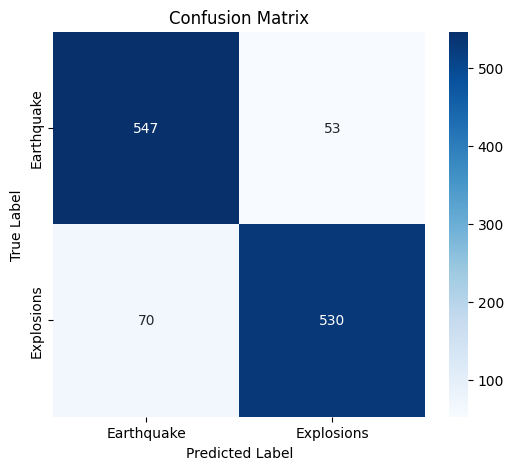

In [18]:
## Performance with best model
def plot_confusion_matrix(y_test, y_pred, labels=None):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
labels = ['Earthquake', 'Explosions']  # Modify based on your classes
plot_confusion_matrix(y_test, y_pred, labels)

## Classification report with the best model

In [30]:
def plot_classification_report(y_test, y_pred):
    report = classification_report(y_test, y_pred, target_names=['Earthquake', 'Explosion'], output_dict=True)
    df_report = pd.DataFrame(report).T
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_report.iloc[:2, :2].astype(float), annot=True, cmap='Blues', fmt='.2f')
    plt.title('Classification Report')
    plt.show()

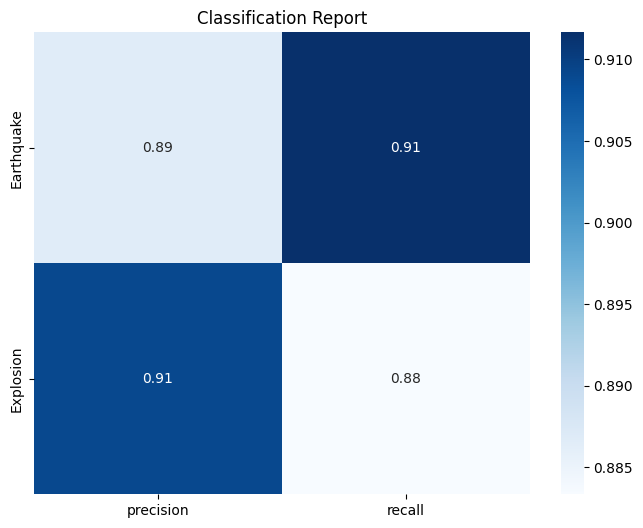

In [31]:
# Calculate the classification report
plot_classification_report(y_test, y_pred)

## Computing the feature importance

In [32]:
num_iter = 10
f_imp = []

for i in tqdm(range(num_iter)):

    # Apply random undersampling using imbalanced-learn library
    rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface event':0, 'noise':0})
    X_resampled, y_resampled = rus.fit_resample(temp_X, y)

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the LabelEncoder on the text labels and transform them to numeric labels
    y_num = label_encoder.fit_transform(y_resampled)


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)

    # Perform randomized grid search cross-validation
    best_model.fit(X_train, y_train)


    f_imp.append(best_model.feature_importances_)

100%|██████████| 10/10 [02:10<00:00, 13.09s/it]


In [33]:
## averaging the importance over the iterations
final_imp = np.mean(f_imp, axis = 0)
## feature labels
features = X_train.columns.values
# Initialize a numpy array with the color 'darkred' for each feature, specifying a string length of 8
feature_colors = np.array(['darkred'] * len(features), dtype='<U8')
feature_names = features

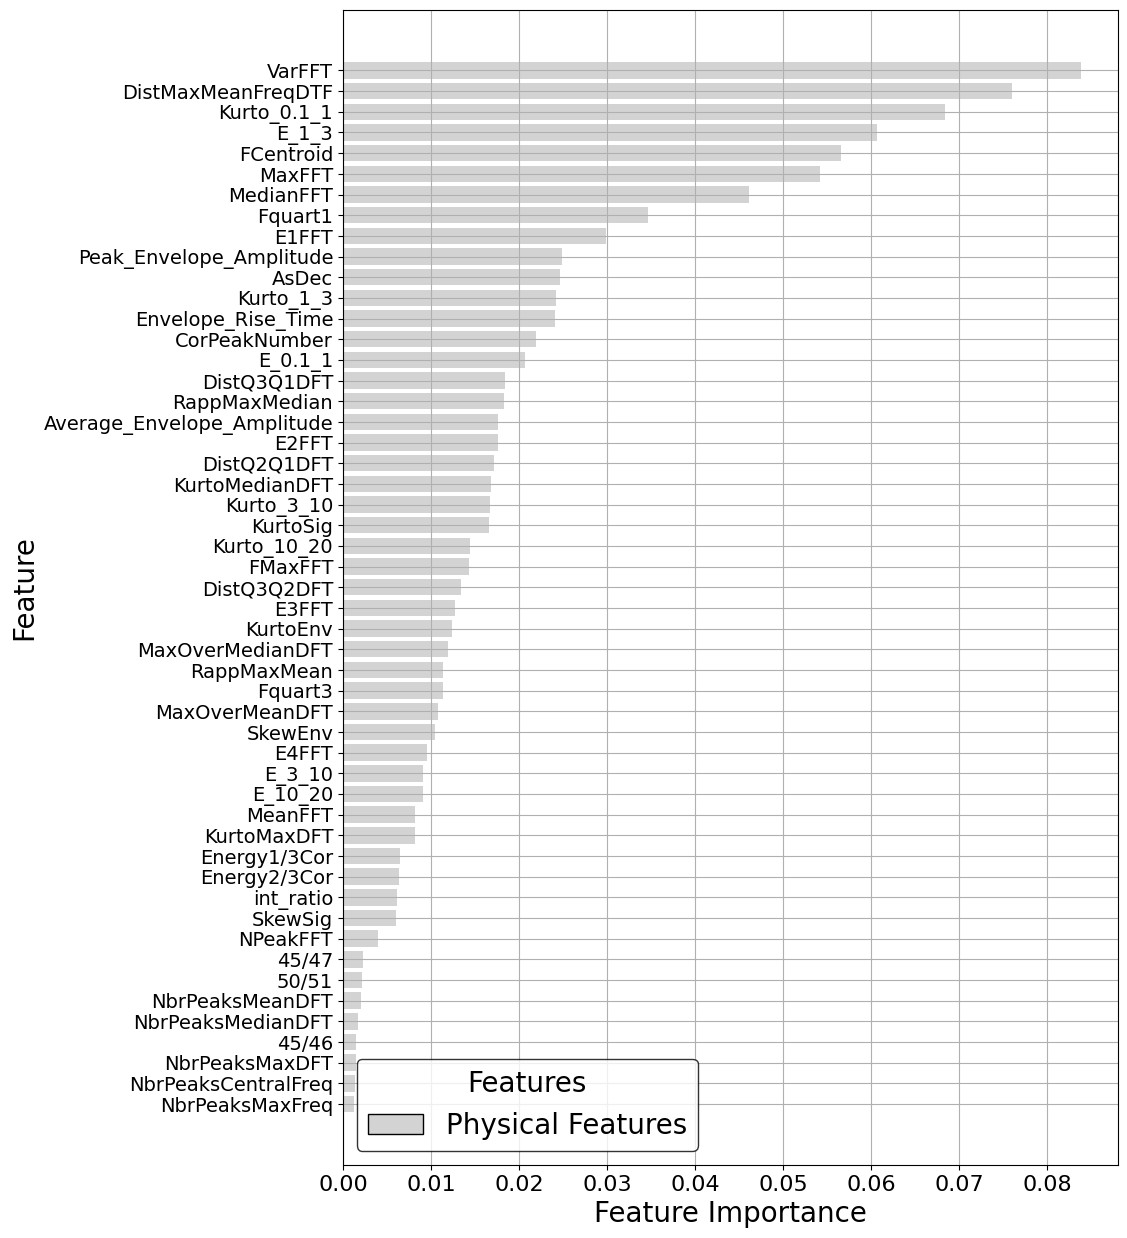

In [34]:
plt.style.use('default')

# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 16  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels

# Sample feature importances and feature labels
feature_importances = final_imp
# Remove "0_" prefix from features that contain it
feature_labels = np.array([name[2:] if name.startswith("0_") else name for name in features])

# Sort feature importances and feature labels together
sorted_indices = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k], reverse=True)
sorted_feature_importances = [feature_importances[i] for i in sorted_indices]
sorted_feature_labels = [feature_labels[i] for i in sorted_indices]

# Define a function to assign colors
def assign_colors(feature):
    if feature in ["hod", "dow", "moy"]:
        return "black"
    else:
        return "lightgray"

# Use the function to assign colors to your features
colors = [assign_colors(feature) for feature in sorted_feature_labels]

# Plotting
plt.figure(figsize=(10, 15))
bars = plt.barh(sorted_feature_labels, sorted_feature_importances, color=colors)

# Create legend handles and labels
legend_handles = [plt.Rectangle((0,0),1,1, color='lightgray', ec='black')]
legend_labels = ['Physical Features']

plt.legend(legend_handles, legend_labels, title='Features', title_fontsize=20, frameon=True, fontsize = 20, facecolor='white', edgecolor='black')

plt.xlabel('Feature Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top

# Set y-axis tick label size
plt.yticks(fontsize=14)
plt.grid('on')

# Save the figure in high-resolution
plt.savefig('../figures/feature_importances_binary.png', dpi=300, bbox_inches='tight')

plt.show()

## Plotting the most important features for binary discrimination

/home/ak287/PNW_Seismic_Event_Classification/notebooks/../src/utils.py:238: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  (df >= df.quantile(lower_quantile)) &
/home/ak287/PNW_Seismic_Event_Classification/notebooks/../src/utils.py:239: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  (df <= df.quantile(upper_quantile))


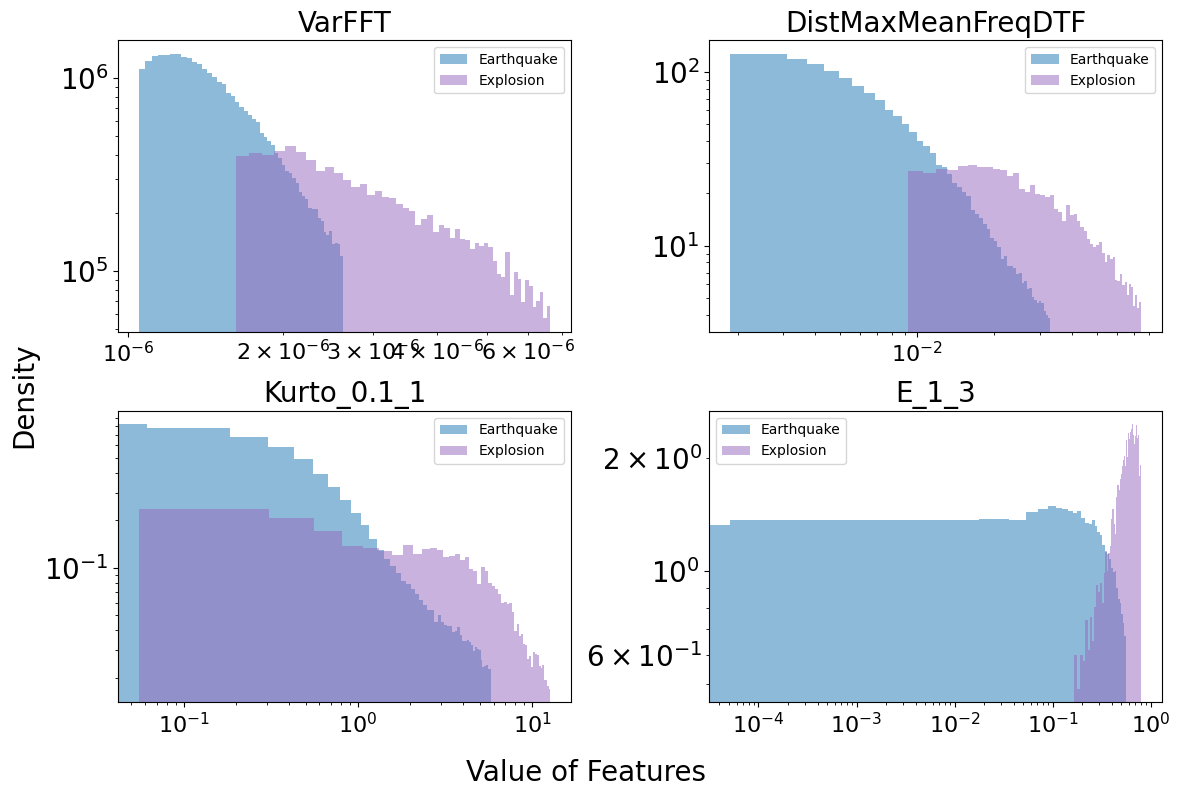

In [35]:
no_df = features_noise_physical
eq_df = features_earthquake_physical
su_df = features_exotic_physical[features_exotic_physical['source'] == 'surface event']
exp_df = features_explosion_physical

filtered_no = interquartile(no_df)
filtered_su = interquartile(su_df)
filtered_eq = interquartile(eq_df)
filtered_exp = interquartile(exp_df)


# Define a function for histogram plotting
def plot_histogram(ax, feature_data, label, color, num_bins, title):
    ax.hist(x=feature_data, bins=num_bins, density=True, color=color, alpha=0.5, label=label)
    ax.legend()
    ax.set_title(title, fontsize=20)

# Define common parameters
num_bins = 50
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[12, 8])

# Define features and labels
features = {
    'VarFFT': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    'DistMaxMeanFreqDTF': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    'Kurto_0.1_1': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    'E_1_3': [filtered_eq, filtered_exp, filtered_no, filtered_su]
}
labels = ['Earthquake', 'Explosion', 'Noise', 'Surface']
colors = ['#1f77b4', '#9467bd', '#d62728',  '#2ca02c']

# Iterate over features and plot histograms
for idx, (feature, (filtered_eq, filtered_exp, filtered_no, filtered_su)) in enumerate(features.items()):
    row = idx // 2
    col = idx % 2
    plot_histogram(ax[row, col], filtered_eq[feature].values, labels[0], colors[0], num_bins, feature)
    plot_histogram(ax[row, col], filtered_exp[feature].values, labels[1], colors[1], num_bins, feature)
    #plot_histogram(ax[row, col], filtered_no[feature].values, labels[2], colors[2], num_bins, feature)
    #plot_histogram(ax[row, col], filtered_su[feature].values, labels[3], colors[3], num_bins, feature)
    #ax[row, col].set_xlim(filtered_eq[feature].quantile(0.001), filtered_eq[feature].quantile(0.9))
    ax[row,col].set_xscale('log')
    ax[row,col].set_yscale('log')
    
    
fig.supylabel('Density', fontsize=20)
fig.supxlabel('Value of Features', fontsize=20)
fig.tight_layout()

# Save the figure in high-resolution
plt.savefig('../figures/feature_histograms_binary.png', dpi=300, bbox_inches='tight')

plt.show()


## Performance with manual features added

## We can experiment by removing and adding the manual features in the cell below to see how much they contribute to performance

In [36]:
## extracting metadata information for each kind of source along with features
## source_type_pnsn_label is more reliable label. 


# selecting all the earthquakes and their metadata information. 
a_eq = X_final[X_final['source_type_pnsn_label'] == 'eq']



## removing the ambiguous events, these are the events that were assigned as earthquakes by pnsn but labelled as
## explosion in USGS ANSS catalog. 
a_eq = a_eq[a_eq['source_type'] != 'explosion']


## selecting all the explosions specifically px, (which is mainly quarry blasts)
a_px = X_final[X_final['source_type_pnsn_label'] == 'px']
# removing the ambiguous events. 
a_px = a_px[a_px['source_type'] != 'earthquake']

a_su = X_final[X_final['source_type'] == 'surface event']
a_no = X_final[X_final['source_type'] == 'noise']



# Extract event IDs for each source type
eq_ids, px_ids, su_ids, no_ids = (
    np.unique(a['event_id'].values) for a in [a_eq, a_px, a_su, a_no]
)



## Specifying a random seed for the reproducibility. 
np.random.seed(123) 


## randomizing along the time. 
r1 = np.random.randint(0, len(eq_ids), 5000)
train_eq = eq_ids[r1]

## randomizing along the time. 
r2 = np.random.randint(0, len(px_ids), 5000)
train_px = px_ids[r2]

## randomizing along the time. 
r3 = np.random.randint(0, len(su_ids), 5000)
train_su = su_ids[r3]

## randomizing along the time
r4 = np.random.randint(0, len(no_ids), 5000)
train_no = no_ids[r4]



mask_eq = np.ones(eq_ids.shape, dtype = bool)
mask_eq[r1] = False

mask_px = np.ones(px_ids.shape, dtype = bool)
mask_px[r2] = False

mask_su = np.ones(su_ids.shape, dtype = bool)
mask_su[r3] = False

mask_no = np.ones(no_ids.shape, dtype = bool)
mask_no[r4] = False

test_eq = eq_ids[mask_eq]
test_px = px_ids[mask_px]
test_su = su_ids[mask_su]
test_no = no_ids[mask_no]



# concatenating training ids
all_train_ids = np.concatenate([train_eq,train_px])

# concatenating testing ids
all_test_ids = np.concatenate([test_eq,test_px])

# allocating event id as index
X_final.index = X_final['event_id'].values


# extracting training and testing values
X_train = X_final.loc[all_train_ids]
X_test = X_final.loc[all_test_ids]



Y_train = X_train['source_type'].values
Y_test = X_test['source_type'].values

In [37]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
x_train_man = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
x_test_man = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)



In [69]:
def compute_model_performance(x_train = x_train, x_test = x_test, holder = '_phy_binary_', scaler_params = scaler_params):
    
    # initiating a random undersampler for randomly selecting nus traces from each class. 
    # note that these are going to be selected from training dataset which was already separated from testing 
    # dataset for the purpose of computing events wise performance. 
    
    # we have also specified a random state for reproducibility

    # number of samples per each event. 
    nus = 5000
    
    # initiating a random undersampling instance. 
    rus = RandomUnderSampler(sampling_strategy={'earthquake':nus, 'explosion':nus}, random_state = 42)
    
    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()
    # Converting the textual labels into numerical labels
    y_num_test = label_encoder.fit_transform(Y_test)
    
    ## Creating the training dataset on which the model will be trained. 
    # randomly taking 5000 samples per class from the training dataset
    X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)
    # Fit the LabelEncoder on the text labels and transform them to numeric labels
    y_num_res = label_encoder.fit_transform(y_resampled)

    # No class weight since we are taking equal number of elements in each class. 
    best_model.class_weight  = None
    # fitting the model. 
    print('Fitting the model on 5000 randomly sampled traces per class')
    best_model.fit(X_resampled, y_num_res)
    
    
    
    
    print('Computing the trace wise performance on the global dataset')
    y_pred = best_model.predict(x_test)
    
    labels = ['Earthquake','Explosion']
  
    plot_confusion_matrix(y_num_test, y_pred, labels)
    # Calculate the classification report
    plot_classification_report(y_num_test, y_pred)

    
    print('Computing event wise performance')
    probs_all = best_model.predict_proba(x_test)

    X_test['labelled'] = y_num_test
    X_test['classified'] = y_pred
    X_test['eq_probability'] = probs_all[:,0]
    X_test['px_probability'] = probs_all[:,1]


    # computing the labels and event ids corresponding to each event.
    mean_labels = X_test.groupby('event_id').mean()['labelled'].values
    mean_ids = X_test.groupby('event_id').mean().index.values

    # computing the means probabilities of each class for a given event. 
    mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
    mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
 
    
    # assigning a class based on the maximum among the mean probabilities of each class across the stations. 
    temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob]), axis = 0)
    # computing the maximum mean probability
    temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob]), axis = 0)

    
    
    
    
    plot_confusion_matrix(mean_labels, temp_class, labels)
    # Calculate the classification report
    plot_classification_report(mean_labels, temp_class)


    
    print('Computing the performance on the balanced dataset')
    num_iter = 50
    trace_cm = []
    trace_cr = []

    for i in tqdm(range(num_iter)):
        # initiating a random undersampler
        rus = RandomUnderSampler(sampling_strategy={0:2500, 1:2500})


        # randomly taking 2500 samples per class from the training dataset
        x_res_test, y_res_test = rus.fit_resample(x_test, y_num_test)
        
        # computing the result for the balanced classes. 
        y_res_pred = best_model.predict(x_res_test)

        trace_cm.append(confusion_matrix(y_res_test, y_res_pred))
        trace_cr.append(classification_report(y_res_test, y_res_pred, output_dict=True))


    conf_matrix = np.mean(trace_cm, axis = 0)
    # Flatten the confusion matrix to true labels and predicted labels
    y_true = []
    y_pred = []

    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix[i])):
            y_true.extend([i] * int(conf_matrix[i][j]))
            y_pred.extend([j] * int(conf_matrix[i][j]))


    plot_confusion_matrix(y_true, y_pred, labels)
    # Calculate the classification report
    plot_classification_report(y_true, y_pred)


    
    
    
    """
    print('Saving results into disk')
    # Saving every result into disk

    # Saving trace results
    ## physical 
    
    
    
    # saving trace wise report
    with open('../results/trace_report'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(trace_report_phy, pickle_file)

    # saving trace wise confusion matrix
    with open('../results/trace_confusion_matrix'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(trace_cm_phy, pickle_file)



    # Saving event wise report
    with open('../results/event_report'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(report_event_phy, pickle_file)

    # Saving event wise confusion matrix
    with open('../results/event_confusion_matrix'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(cf_events_phy, pickle_file)


    # saving balanced trace wise report    
    with open('../results/balanced_trace_report'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(report, pickle_file)


    # saving balanced trace wise confusion matrix. 
    with open('../results/balanced_trace_confusion_matrix'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(conf_matrix, pickle_file)


    print('Saving trained model')
    dump(best_model, '../results/best_rf_model_all_features'+holder+filename+'.joblib')
    
    
    # Original array
    array = x_train.columns.values

    # Elements to remove
    elements_to_remove = ['hod', 'dow', 'moy']

    
    # Create a boolean mask
    mask = ~np.isin(array, elements_to_remove)

    # Apply the mask to filter the array
    filtered_array = array[mask]
    
    new_scaler_params = scaler_params
    new_scaler_params.index = new_scaler_params['Feature']
    new_scaler_params = new_scaler_params.loc[filtered_array]
    
    print('saving the scalar params')
    new_scaler_params.to_csv('../results/scaler_params'+holder+filename+'.csv', index = False)
    
    """
    

Fitting the model on 5000 randomly sampled traces per class
Computing the trace wise performance on the global dataset


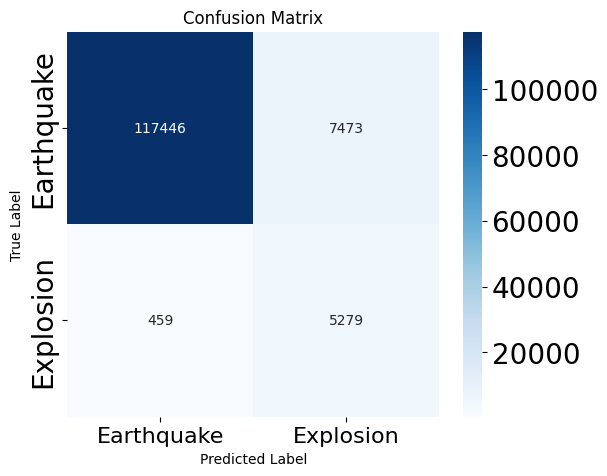

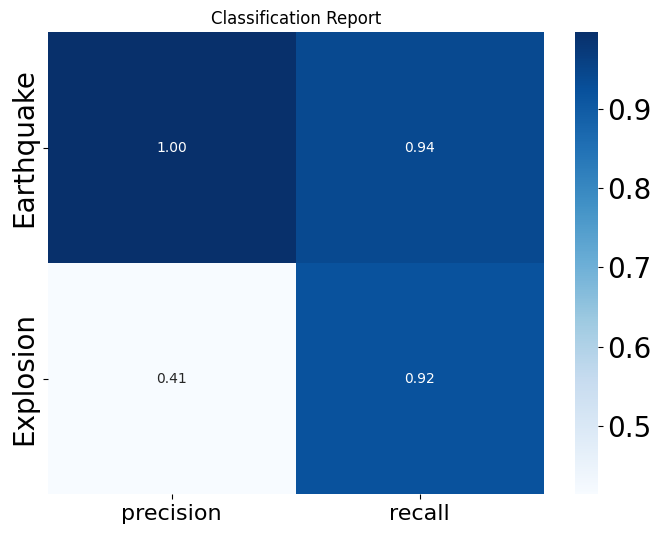

Computing event wise performance


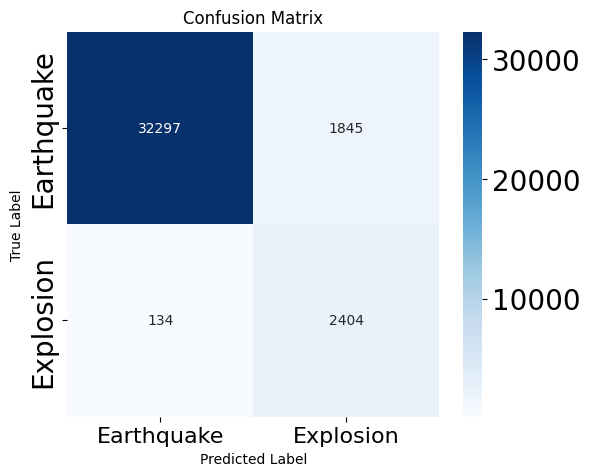

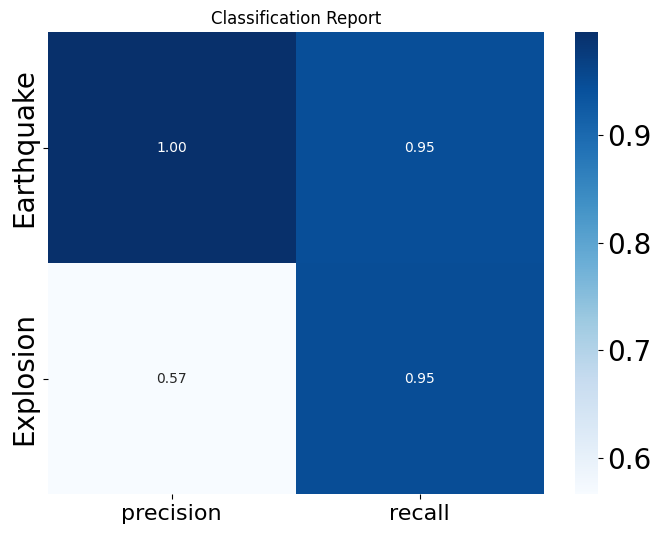

  0%|          | 0/50 [00:00<?, ?it/s]

Computing the performance on the balanced dataset


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


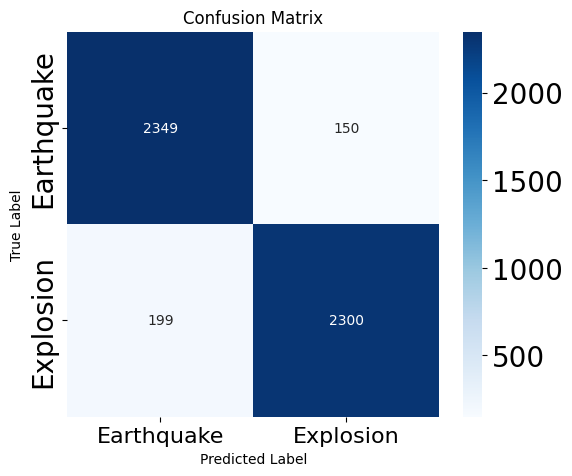

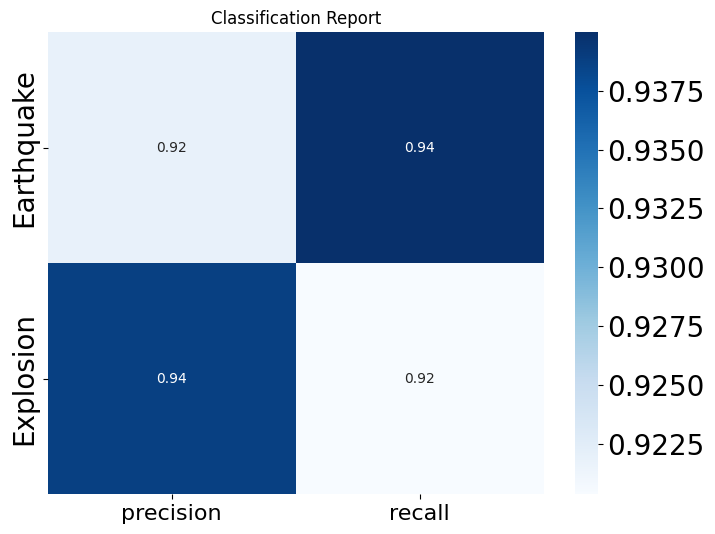

In [70]:
## computing all the results just for physcial features. 
compute_model_performance(x_train = x_train_man, x_test = x_test_man, holder = '_phy_man_binary_')